In [1]:
import cv2
import numpy as np
# import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import ones,vstack
from numpy.linalg import lstsq

# Convolution kernel

In [2]:
def convolution(img, kernel):
    #define the image, and kernel height and width
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = int((kernel_h - 1) / 2)
    pad_w = int((kernel_w - 1) / 2)
    #define the output image
    img_output = np.zeros(img.shape)

    #padded_img is the image which have the shape of image + 1
    padded_img = np.zeros((img_h + (2 * pad_h), img_w + (2 * pad_w)))
    padded_img[pad_h:padded_img.shape[0] - pad_h, pad_w:padded_img.shape[1] - pad_w] = img

    #Two for loops to convolve the image
    for i in range(img_h):
        for j in range(img_w):
            img_output[i, j] = np.sum(kernel * padded_img[i:i + kernel_h, j:j + kernel_w])

    return img_output

# Sobel edge detection

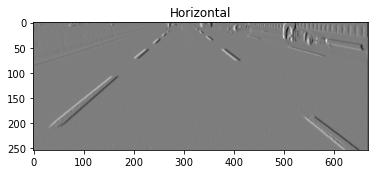

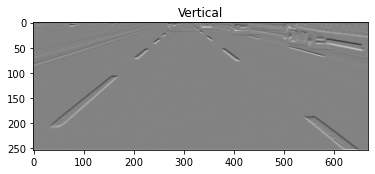

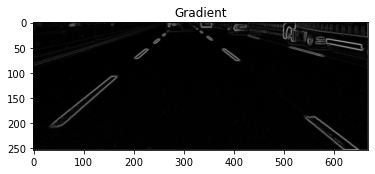

In [3]:
def sobel_edge_detection(image):
    filterX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    filterY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    ##Horizontal
    Gx = convolution(image, filterX)
    plt.imshow(Gx, cmap='gray')
    plt.title("Horizontal")
    plt.show()
    ##Vertical
    Gy = convolution(image, filterY)
    plt.imshow(Gy, cmap='gray')
    plt.title("Vertical")
    plt.show()
    ##Gradient
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    ##Normalize G betwen 0 and 255
    G *= 255.0 / G.max()
    plt.imshow(G, cmap='gray')
    plt.title("Gradient")
    plt.show()
    return G
## Run to see the output
image = cv2.imread('lane.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
output = sobel_edge_detection(image)

# Threshold function

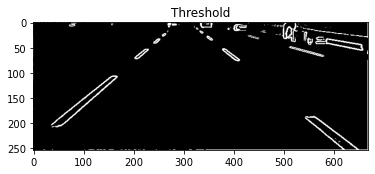

In [4]:
def threshold(image, value):
    output = np.zeros(image.shape)
    #find the pixel location which greater, and smaller to the threshold value
    strong_r, strong_c = np.where(image >= value)
    weak_r, weak_c = np.where(image < value)
    #Replace it by 255, and 0, respectively
    output[strong_r, strong_c] = 255
    output[weak_r, weak_c] = 0
    return output
output_official = threshold(output, 50)
plt.imshow(output_official, cmap='gray')
plt.title("Threshold")
plt.show()

# Processing data and Function to apply RANSAC algorithm

In [5]:
def processing_data():
    #Increase the threshold for more accuracy in RANSAC
    output_new = threshold(output, 110)
    #Transform image to xy cartesian coordinate
    b = output_new.flatten()
    y,x = np.indices(output_new.shape).reshape(-1,len(b))
    #Remove 0
    y,x = np.where(output_new)#remove if a[i][j] = 0
    #Remove 0
    x = x[np.where(y)] #Remove if y[i] = 0
    y = y[np.where(y)] #Remove if y[i] = 0
    #Concatenate x, and y
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    #Save the initial
    xy_initial = xy.copy()
    return xy, xy_initial

In [6]:
def change_to_list(data):
    # b is z coordinates, put it equal to 1
    # because x' = x/z , y' = y/z
    b = np.ones((data[:,0:1].shape[0], 1))
    # Stack z to the x,y to become array[x,y,z]
    a = np.hstack((data[:,0:1], data[:,1:2], b))
    # Transform array to list to use random.sample
    a = list(a)
    return a
    

In [7]:
def remove_line(data, a):
    k=[]
    for j in range(0,data.shape[0]):
        #dot product < (a+b)*epsilon with a,b is in this eqn: ax + by + c = 0
        if abs(np.dot(line, a[j].reshape(-1,1))) < abs((line[0]+line[1]))*6:
            k.append(j)
    data = np.delete(data, k, axis=0)
    return data

In [8]:
def line_equation(u):
    #Calculate the equation y = ax + b
    #u[0][0:2], u[1][0:2] are the 2 points from RANSAC
    points = [u[0][0:2],u[1][0:2]]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m,c

In [9]:
def draw_line(m, c):
    xcoor = np.linspace(0,668,669)
    ycoor = m*xcoor+c
    axes = plt.gca()
    # Set x, and y limit 
    axes.set_xlim([0,668])
    axes.set_ylim([0,254])
    axes.invert_yaxis()
    plt.plot(xcoor,ycoor, '-r')
    # Save Figure after RANSAC to open together
    plt.savefig(f'detection_{i}.png')

In [10]:
def show_4_image():
    from pylab import rcParams
    # Read the figure
    z1 = cv2.imread('detection_1.png')
    z2 = cv2.imread('detection_2.png')
    z3 = cv2.imread('detection_3.png')
    z4 = cv2.imread('detection_4.png')
    # Reorder the RGB sinc OpenCV read it as BGR
    b,g,r = cv2.split(z1)           
    rgb_img1 = cv2.merge([r,g,b])
    b,g,r = cv2.split(z2)           
    rgb_img2 = cv2.merge([r,g,b]) 
    b,g,r = cv2.split(z3)           
    rgb_img3 = cv2.merge([r,g,b]) 
    b,g,r = cv2.split(z4)           
    rgb_img4 = cv2.merge([r,g,b]) 
    plt.figure()
    rcParams['figure.figsize'] = 20, 20
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(4,1) #4 row, 1 columns
    # use the created array to output your multiple images. 
    # In this case I have stacked 4 images vertically
    axarr[0].imshow(rgb_img1)
    axarr[1].imshow(rgb_img2)
    axarr[2].imshow(rgb_img3)
    axarr[3].imshow(rgb_img4)

# RANSAC ALGORITHM

In [11]:
def ransac(xys, iter):
    max = 0
    for i in range(iter):
        # random 2 points in the image data point
        c = random.sample(a, 2)
        # if function to prevent the condition described in the report
        if c[0][1] != c[1][1] and c[0][1]> 80 and c[1][1]> 80:
            # compute the line between these two points by the cross product
            l = np.cross(c[0], c[1])
            count = 0
            # looping all the data in the image data point
            for j in a:
                # compute the dot product of each point to the line
                check = np.dot(l, np.array(j).reshape(-1,1))
                # check if it equal to 0 or not
                # better == 0, or < 1e - 6
                if abs(check) == 0:
                    count += 1
            if max < count:
                max = count
                c_out = c
                line = l
    # return the best line and these 2 points            
    return c_out, line

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advi

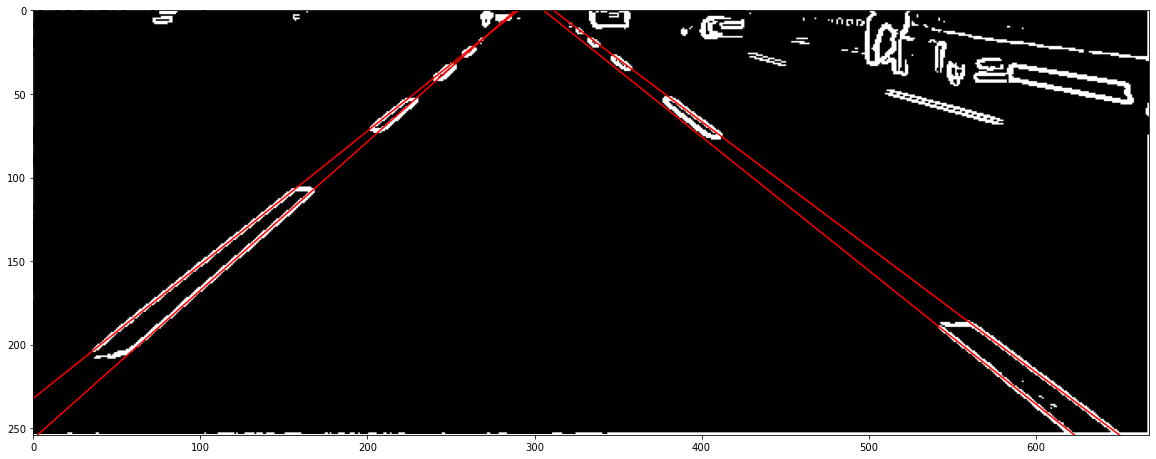

<Figure size 1440x1440 with 0 Axes>

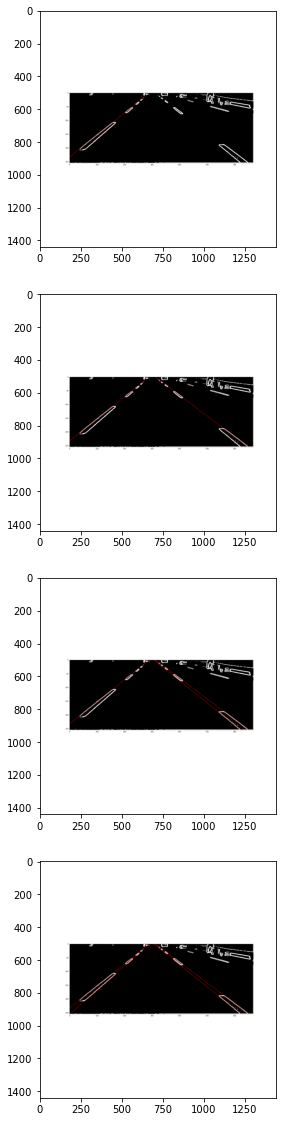

In [15]:
xy, xy_initial = processing_data()
xy = xy_initial # keep this one to run again 
for i in range(1,5):
    a = change_to_list(xy)
    u , line = ransac(a, 1000)
    plt.imshow(output_official, cmap='gray')
    # get the line equation
    m,c = line_equation(u)
    # draw line in the image, and save image
    draw_line(m, c)
    # remove the point which in the line to extract another line
    xy = remove_line(xy, a)
show_4_image()